In [11]:
import numpy as np
import math
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import random

np.set_printoptions(suppress=True, formatter={'float': '{:0.3f}'.format})

In [55]:
gamma = 0.75

def update(A, hess, n, algo='article', rand=False, worst_case=False):
    dim = 2
    gamma_n = n**(-gamma)
    if rand:
        z = random.randint(0, 1)
        if worst_case:
            z = 0
        P = np.zeros_like(A)
        P[z,z] = dim
        hess_tilde = hess @ P
        prod = A @ hess_tilde
    else:
        hess_tilde = hess
        prod = A @ hess

    if gamma_n * np.linalg.norm(hess_tilde) > 2:
        A_new = A
    elif algo == 'old':
        A_new = A - gamma_n * (prod + prod.T- 2 * np.eye(2))

    elif algo == 'bruno':
        A_new = A - gamma_n * (prod + prod.T - 2 * np.eye(2)) + (gamma_n**2) * hess_tilde.T @ prod

    elif algo == 'article':
        if not rand:
            P = np.eye(dim)
        A_new = A - gamma_n * (prod + prod.T - 2 * P) + (gamma_n**2) * hess_tilde.T @ prod
    
    else:
        raise ValueError('algo not recognized')
  
    eig = np.linalg.eigvals(A_new)
    return A_new, np.min(eig), np.max(eig)


In [56]:
def plot_errors(list_max_eig, list_min_eig, list_err, list_diff, dim, n_min=0, n_max=-1):
    n_min = min(n_min, len(list_max_eig))
    n_max = len(list_max_eig) if n_max == -1 else min(n_max, len(list_max_eig))

    fig, axs = plt.subplots(2, 2)
    fig.suptitle('Results')
    x = np.arange(start=n_min, stop=n_max)
    y = 1 + (2*dim / (1-gamma)) * x**(1-gamma)

    axs[0, 0].plot(x, list_max_eig[n_min:n_max])
    axs[0, 0].plot(x,y, label='n^(1-gamma)')
    axs[0, 0].set_title('max eigenvalues')
    axs[0, 0].legend()

    axs[0, 1].plot(x, list_min_eig[n_min:n_max])
    axs[0, 1].set_title('min eigenvalues')

    axs[1, 0].plot(x, list_err[n_min:n_max])
    axs[1, 0].set_title('error')

    axs[1, 1].plot(x, list_diff[n_min:n_max])
    axs[1, 1].set_title('diff')

    fig.tight_layout(pad=1.0)
    plt.show()



In [57]:
dim = 2
A_0 = np.eye(dim)
# A_0 = np.array([[1, 0],
#                 [0, 10]])
print(f'A_0:\n {A_0}\n')

a = 10
epsilon = 1e-6
H = np.array([[1/a, 1],
                [1, a+epsilon]])
# H = np.zeros_like(A_0)

print(f'H:\n {H}\n')
eig = np.linalg.eigvals(H)
print(f'valeurs propres H:\n {eig}\n')
print(f'conditionnement de H: {np.max(eig)/np.min(eig)}\n')
print(f'norme d operateur de H: {np.linalg.norm(H, 2)}\n')
print(f'norme de frobenius H: {np.linalg.norm(H)}\n')


H_inv = np.linalg.inv(H)
# A_0 = hess_inv
print(f'H_inv:\n {H_inv}\n')
eig_inv = np.linalg.eigvals(H_inv)
print(f'valeurs propres hess_inv:\n {eig_inv}\n')



A_0:
 [[1.000 0.000]
 [0.000 1.000]]

H:
 [[0.100 1.000]
 [1.000 10.000]]

valeurs propres H:
 [0.000 10.100]

conditionnement de H: 1020100267.4731556

norme d operateur de H: 10.10000099009901

norme de frobenius H: 10.10000099009901

H_inv:
 [[100000009.942 -9999999.994]
 [-9999999.994 999999.999]]

valeurs propres hess_inv:
 [101000009.842 0.099]



  0%|          | 0/1000 [00:00<?, ?it/s]

ValueError: x and y must have same first dimension, but have shapes (1001,) and (1000,)

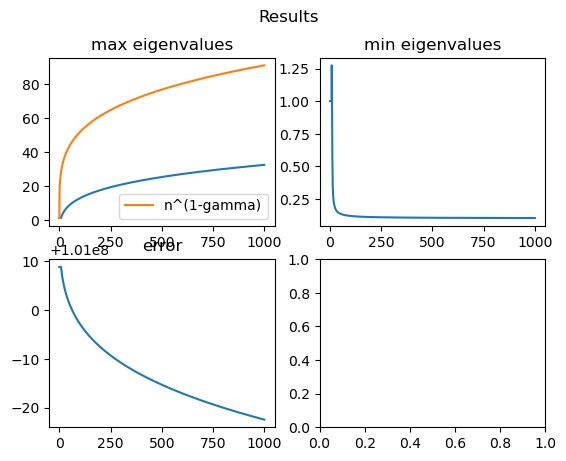

In [53]:

# Diverge because we do not have gamma_n beta_n < 1
# n_min = 1

# Rank at which gamma_n |Q_n| < 1
# n_min = int(np.ceil( (2 * np.linalg.norm(hess))**(4/3)))
# print(f'n_min for <1: {n_min}')

# n_max = n_min + int(1e6)

n_max = int(1e3)

A = A_0.copy()
list_max_eig = [np.max(np.linalg.eigvals(A_0))]
list_min_eig = [np.min(np.linalg.eigvals(A_0))]
list_err = [np.linalg.norm(H_inv - A_0)]
list_diff = []

for n in tqdm(range(1, n_max+1)):
    # A_new, min_eig, max_eig  = update(A, hess, n, algo='article', rand=True, worst_case=True)
    A_new, min_eig, max_eig  = update(A, H, n, algo='article', rand=False)
    list_max_eig.append(max_eig)
    list_min_eig.append(min_eig)
    list_diff.append(np.linalg.norm(A_new - A))
    A = A_new
    list_err.append(np.linalg.norm(H_inv - A))

plot_errors(list_max_eig, list_min_eig, list_err, list_diff, dim)


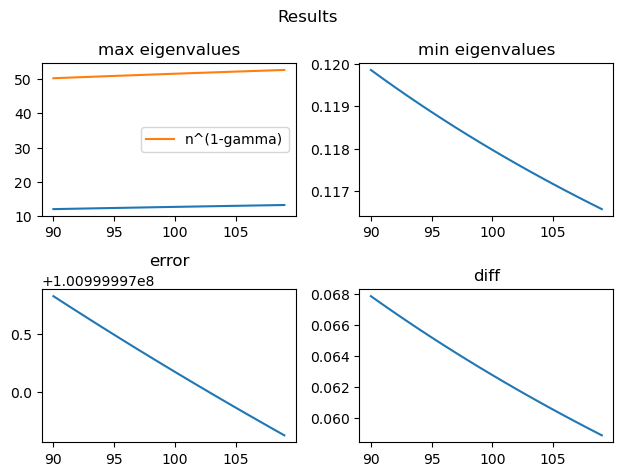

In [54]:
n_min = 90
n_max = 110

plot_errors(list_max_eig, list_min_eig, list_err, list_diff, dim, n_min=n_min, n_max=n_max)

In [17]:
product = A @ H
product2 = H @ A
res = A @ H + H @ A - 2*np.eye(2)

H_inv = np.linalg.inv(H)
diff = A - H_inv

print(f'product:\n {product}\n')
print(f'product2:\n {product2}\n')
print(f'res:\n {res}\n')
print(f'norm of A_n - H_inv: {np.linalg.norm(diff)}\n')

print(f'A_n:\n {A}\n')
print(f'H_inv:\n {H_inv}\n')

print(f'eigenvalues of A_n:\n {np.linalg.eigvals(A)}\n')
print(f'eigenvalues of H_inv:\n {np.linalg.eigvals(H_inv)}\n')

product:
 [[0.010 0.102]
 [0.102 1.019]]

product2:
 [[0.010 0.102]
 [0.102 1.019]]

res:
 [[-1.980 0.204]
 [0.204 0.038]]

norm of A_n - H_inv: 100999977.51038203

A_n:
 [[32.013 -3.191]
 [-3.191 0.421]]

H_inv:
 [[100000009.942 -9999999.994]
 [-9999999.994 999999.999]]

eigenvalues of A_n:
 [32.332 0.102]

eigenvalues of H_inv:
 [101000009.842 0.099]

